# Imports

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib
from matplotlib import cm
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

matplotlib.style.use('ggplot')
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

In [2]:
###### DO NOT MODIFY THIS FUNCTION #####
def tokenize_doc(doc):
    """
    Tokenize a document and return its bag-of-words representation.
    doc - a string representing a document.
    returns a dictionary mapping each word to the number of times it appears in doc.
    """
    bow = defaultdict(float)
    tokens = doc.split()
    lowered_tokens = map(lambda t: t.lower(), tokens)
    for token in lowered_tokens:
        bow[token] += 1.0
    return dict(bow)
###### END FUNCTION #####

## Retrieve Data

In [3]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

/Users/Jojo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration

In [4]:
train_data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [5]:
train_data.head(30)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


# Baseline model

In [6]:
# feature: words per question

def count_words(question):
    question = str(question)
    words = question.split()
    return len(words)

train_data["q1l"] = train_data["question1"].apply(count_words)
train_data["q2l"] = train_data["question2"].apply(count_words)
test_data["q1l"] = test_data["question1"].apply(count_words)
test_data["q2l"] = test_data["question2"].apply(count_words)

In [7]:
# feature: repeated words per question

def count_repeats(row):
    q1 = str(row['question1']).lower()
    q2 = str(row['question2']).lower()
    
    w1 = q1.split()
    w2 = q2.split()
    
    count = 0
    
    if len(w1) > len(w2):
        for word in w1:
            if word in w2:
                count = count + 1
    else:
        for word in w2:
            if word in w1:
                count = count + 1
    
    return count

train_data["repeats"] = train_data.apply(count_repeats, axis=1)
test_data["repeats"] = test_data.apply(count_repeats, axis=1)

##### Initial Test

In [8]:
tp = 0
tn = 0
fp = 0
fn = 0

for index, row in train_data.iterrows():
    if (row['repeats']/row['q1l'] + row['repeats']/row['q2l'])/2 >= 0.5:
        if row['is_duplicate'] == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if row['is_duplicate'] == 1:
            fn = fn + 1
        else:
            tn = tn + 1

In [9]:
print("Accuracy: ", (tp+tn)/(tp+tn+fp+fn))
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives: ", tp)
print("True negatives: ", tn)

Accuracy:  0.6695490860520913
False positives:  87292
False negatives:  46306
True positives:  102957
True negatives:  167735


#### Results Visualization

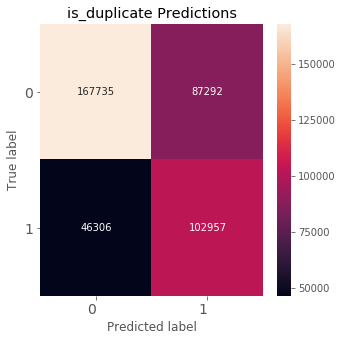

In [10]:
plt.figure(figsize=[5,5])
heatmap = sb.heatmap([[tn,fp],[fn,tp]], annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("is_duplicate Predictions")
plt.show()

##### Test with equal sample size

In [11]:
g = train_data.groupby('is_duplicate')
g = g.apply(lambda x: x.sample(g.size().min()))
g

id    qid1    qid2  \
is_duplicate                                  
0            48090    48090   85788   85789   
             210415  210415   17268  314955   
             389499  389499  418856  521990   
             282417  282417  402350  402351   
             61853    61853  107921  107922   
             12906    12906   24820   24821   
             135417  135417  216263  216264   
             390040  390040  133843  358654   
             222280  222280  329792  329793   
             380658  380658  512301  512302   
             327347  327347    3240  453767   
             136421  136421  217670  217671   
             225801  225801  334230  334231   
             392887  392887  525613  525614   
             209017  209017  313173  313174   
             137558  137558   14678   11668   
             168755  168755  109962  261320   
             385753  385753  497510  325212   
             168897  168897  261513  149595   
             10031    10031   19472   19473   
             272118  272118   10427  144085   
             242581  242581  354821   20152   
             197111  197111  297991   31262   
             311829  311829  436171  436172   
             229511  229511  103124  313667   
             126025  126025  203211  203212   
             210352  210352  207374  295300   
             376276  376276  507400  507401   
             251475  251475  365591  141862   
             298686  298686   99657   84683   
...                     ...     ...     ...   
1            85473    85473  144308  144309   
             244102  244102  293730  356669   
             188334  188334   35564     885   
             120691  120691  195727  195728   
             190340  190340  120218  289392   
             114631  114631  187086  177450   
             42056    42056   75838   75839   
             314362  314362  168403   68209   
             335022  335022  462270  462271   
             216787  216787  202305   71756   
             300562  300562   66587   54811   
             243703  243703   64271   16167   
             105338  105338    1454   22652   
             156978  156978  245552  245553   
             187531  187531  100713  132624   
             12883    12883   24780   24781   
             230611  230611   69177  340192   
             53147    53147   94002   94003   
             374773  374773  366547  430576   
             181960  181960   26937  100854   
             20949    20949   39481   39482   
             83371    83371  141158  141159   
             236010  236010  266311  306865   
             254449  254449  369169  369170   
             368055  368055  332634  498394   
             308840  308840  267786  432739   
             215943  215943  242572  318892   
             150880  150880   66482   54505   
             330934  330934  457747  368558   
             283018  283018  403051  403052   

                                                             question1  \
is_duplicate                                                             
0            48090   I'm opening my first boutique. Where should I ...   
             210415  Which is the best government job in India and ...   
             389499  How can I train my bladder to go to the toilet...   
             282417  What are the strongest majors in terms of job ...   
             61853   How is it easy for Egyptian to find an embedde...   
             12906   What is difference between multinational and i...   
             135417      How can one find the passion you're born for?   
             390040  My close guy friend and I hooked up but I was ...   
             222280  What are some good tips for maintaining my bik...   
             380658  How do you troubleshoot the camera in Photo Bo...   
             327347  How was Thich Quang Duc able to burn himself t...   
             136421  Does owning a car affect the ability to get a ...   
             225801  Should

In [12]:
trp = 0
trn = 0
fap = 0
fan = 0

for i, row in g.iterrows():
    if (row['repeats']/row['q1l'] + row['repeats']/row['q2l'])/2 >= 0.5:
        if row['is_duplicate'] == 1:
            trp = trp + 1
        else:
            fap = fap + 1
            if fap < 15:
                print("False positive:")
                print(row['question1'])
                print(row['question2'])
                print(" ")
    else:
        if row['is_duplicate'] == 1:
            fan = fan + 1
            if fan < 15:
                print("False Negative:")
                print(row['question1'])
                print(row['question2'])
                print(" ")
        else:
            trn = trn + 1

False positive:
What are the strongest majors in terms of job prospects and what are the weakest majors at Texas Southern University?
What are the strongest majors in terms of job prospects and what are the weakest majors at Texas State?
 
False positive:
What is difference between multinational and international?
What is the difference between a global company and a multinational company?
 
False positive:
Should I go to UC San Diego or UC Davis to study Engineering?
Should I go to UC San Diego or UC Davis to study Computer Science?
 
False positive:
What are the advantages and disadvantages of social media?
What are the benefits of social media marketing?
 
False positive:
How can I double my savings?
How do I double $5?
 
False positive:
How competitive is the hiring process at Lakeland Financial?
How competitive is the hiring process at Lakeland Bank?
 
False positive:
What is the most sensible thing you have ever heard someone say?
What is the most embarrassing thing you have ever

In [13]:
print("Accuracy: ", (trp+trn)/(trp+trn+fap+fan))
print("False positives: ", fap)
print("False negatives: ", fan)
print("True positives: ", trp)
print("True negatives: ", trn)

Accuracy:  0.673981495749114
False positives:  51019
False negatives:  46306
True positives:  102957
True negatives:  98244


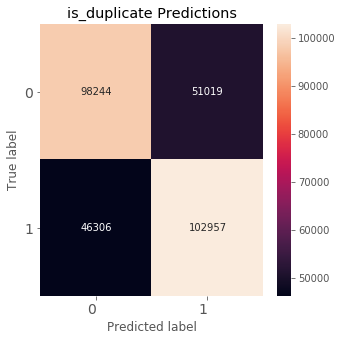

In [14]:
plt.figure(figsize=[5,5])
heatmap2 = sb.heatmap([[trn,fap],[fan,trp]], annot=True, fmt="d")
heatmap2.yaxis.set_ticklabels(heatmap2.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap2.xaxis.set_ticklabels(heatmap2.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("is_duplicate Predictions")
plt.show()

### Ready train/validation

In [15]:
features = ["repeats", "q1l", "q2l"]

X = train_data[features]
y = train_data["is_duplicate"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33)

### Random Forest Classifier

0.698566888529112


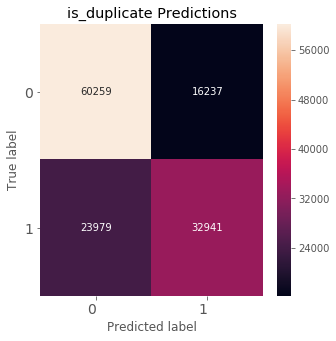

In [16]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_val)
rfc_cm = confusion_matrix(rfc_predict, y_val)
print(accuracy_score(rfc_predict, y_val))

plt.figure(figsize=[5,5])
heatmap = sb.heatmap(rfc_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("is_duplicate Predictions")
plt.show()

## Data Visualization

In [17]:
print(len(train_data[train_data['is_duplicate'] == 1]))
print(len(train_data[train_data['is_duplicate'] == 0]))
print(len(train_data))
print(len(test_data))

149263
255027
404290
3563475


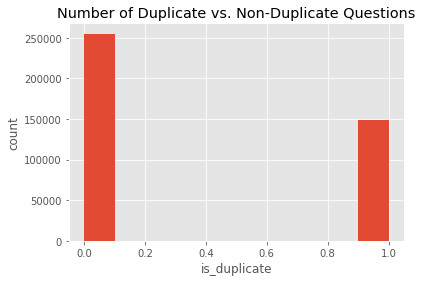

In [18]:
plt.figure()
plt.hist(train_data['is_duplicate'])
plt.xlabel("is_duplicate")
plt.ylabel("count")
plt.title("Number of Duplicate vs. Non-Duplicate Questions")
plt.show()

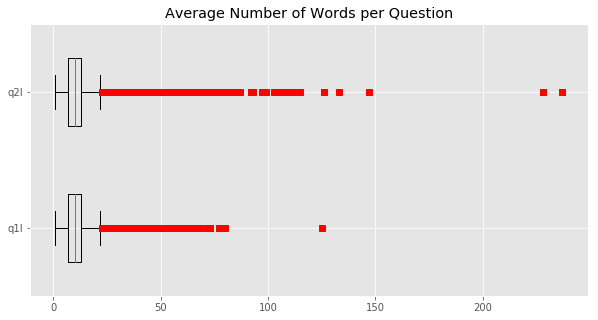

In [19]:
data = [train_data['q1l'], train_data['q2l']]

plt.figure(figsize=[10,5])
plt.boxplot(data, 0, 'rs', 0, widths=[0.5,0.5])
plt.yticks([1,2],["q1l", "q2l"])
plt.title("Average Number of Words per Question")
plt.show()

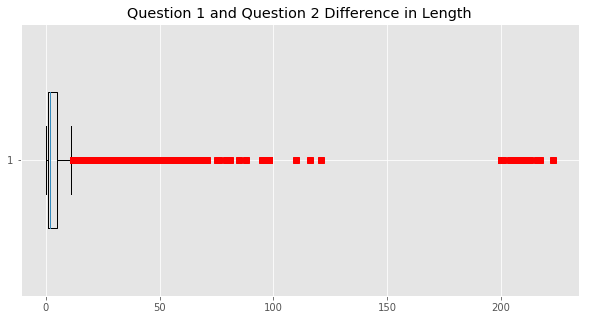

In [20]:
data = abs(train_data['q1l'] - train_data['q2l'])

plt.figure(figsize=[10,5])
plt.boxplot(data, 0, 'rs', 0, widths=[0.5])
plt.title("Question 1 and Question 2 Difference in Length")
plt.show()

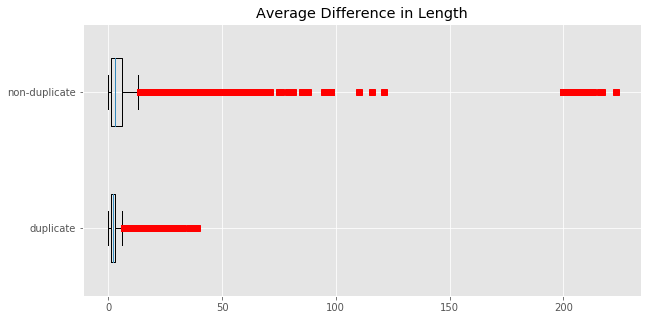

In [21]:
data1 = abs(train_data[train_data['is_duplicate'] == 1]['q1l'] - train_data[train_data['is_duplicate'] == 1]['q2l'])
data2 = abs(train_data[train_data['is_duplicate'] == 0]['q1l'] - train_data[train_data['is_duplicate'] == 0]['q2l'])
data3 = [data1, data2]

plt.figure(figsize=[10,5])
plt.boxplot(data3, 0, 'rs', 0, widths=[0.5,0.5])
plt.yticks([1,2],["duplicate", "non-duplicate"])
plt.title("Average Difference in Length")
plt.show()

In [22]:
duplicate_counts = Counter()
nonduplicate_counts = Counter()

for i, row in g.iterrows():
    question = str(row['question1']) + " " + str(row['question2'])
    if row['is_duplicate'] == 1:
        duplicate_counts.update(tokenize_doc(question))
    else:
        nonduplicate_counts.update(tokenize_doc(question))

In [23]:
nonduplicate_counts = sorted(nonduplicate_counts.items(), key=lambda x: x[1], reverse=True)
duplicate_counts = sorted(duplicate_counts.items(), key=lambda x: x[1], reverse=True)

In [24]:
count = 0
for i in nonduplicate_counts:
    if count == 30:
        break
    print("'" + str(i[0]) + "': " + str(i[1]))
    count = count + 1

'the': 142321.0
'what': 115846.0
'is': 104246.0
'a': 90049.0
'i': 82101.0
'to': 80786.0
'in': 80383.0
'how': 76123.0
'of': 62744.0
'do': 54921.0
'are': 54364.0
'and': 53402.0
'for': 41255.0
'can': 39682.0
'you': 30351.0
'why': 27277.0
'my': 26792.0
'it': 26124.0
'does': 23854.0
'on': 21983.0
'best': 20663.0
'or': 19013.0
'if': 17348.0
'have': 16481.0
'with': 16391.0
'an': 15865.0
'which': 15831.0
'that': 15827.0
'be': 15609.0
'some': 15500.0


In [25]:
count = 0
for i in duplicate_counts:
    if count == 30:
        break
    print("'" + str(i[0]) + "': " + str(i[1]))
    count = count + 1

'the': 133151.0
'what': 112690.0
'is': 90574.0
'how': 89392.0
'i': 73033.0
'to': 66831.0
'do': 61216.0
'in': 57432.0
'a': 56366.0
'are': 52714.0
'of': 51833.0
'can': 46150.0
'and': 41618.0
'best': 34166.0
'you': 32825.0
'for': 30745.0
'why': 29011.0
'my': 25376.0
'on': 21929.0
'which': 16718.0
'it': 16022.0
'be': 15607.0
'your': 15570.0
'does': 15481.0
'some': 15433.0
'get': 14515.0
'if': 13761.0
'should': 12795.0
'will': 12654.0
'that': 12420.0


In [34]:
thing1 = (train_data[train_data['is_duplicate'] == 0]['repeats']/train_data[train_data['is_duplicate'] == 0]['q1l'] + train_data[train_data['is_duplicate'] == 0]['repeats']/train_data[train_data['is_duplicate'] == 0]['q2l'])/2
thing2 = (train_data[train_data['is_duplicate'] == 1]['repeats']/train_data[train_data['is_duplicate'] == 1]['q1l'] + train_data[train_data['is_duplicate'] == 1]['repeats']/train_data[train_data['is_duplicate'] == 1]['q2l'])/2

/Users/Jojo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Jojo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


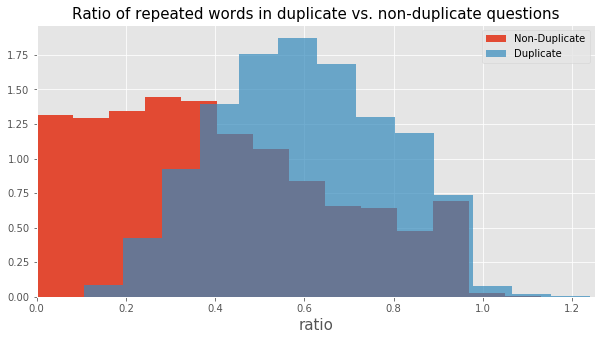

In [38]:
plt.figure(figsize=(10, 5))
plt.hist(thing1, bins=20, normed=True, label='Non-Duplicate')
plt.hist(thing2, bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Ratio of repeated words in duplicate vs. non-duplicate questions', fontsize=15)
plt.xlabel('ratio', fontsize=15)
plt.xlim(0,1.25)
plt.show()